In [15]:

import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm

from bnn_hmc import data
from bnn_hmc import models
from bnn_hmc import nn_loss
from bnn_hmc import train_utils
from bnn_hmc import precision_utils
from bnn_hmc import checkpoint_utils
from bnn_hmc import metrics

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
train_set, test_set, num_classes = data.make_ds_pmap_fullbatch(name="imdb")
labels = onp.array(test_set[1])[0, :]

In [17]:
path = "../runs/sgld/cnn_lstm/" \
       "sgld_wd_5.0_stepsizes_1e-06_1e-06_batchsize_80_epochs10000_500_temp_1.0_seed_0/" \
       "model_step_9999.pt"
ckpt_dict = checkpoint_utils.load_checkpoint(path)
ens_probs = ckpt_dict["ensemble_predicted_probs"]
ens_probs = ens_probs.reshape((25000, 2))

In [33]:
metrics.accuracy(ens_probs, labels)

0.8672

In [34]:
metrics.nll(ens_probs, labels, normalized=True)

0.30445617

In [35]:
curve = metrics.calibration_curve(ens_probs, labels)
print(curve["ece"])

0.009153713538646689


(array([-0.025, -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,  0.01 ,
         0.015,  0.02 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

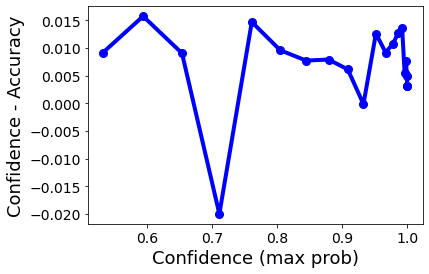

In [51]:
plt.plot(curve['confidence'], curve['confidence'] - curve['accuracy'], linewidth=4, marker='o', markersize=8, 
         color="b", label="T=1", zorder=3)
plt.ylabel('Confidence - Accuracy', fontsize=18)
plt.xlabel('Confidence (max prob)', fontsize=18)
# ticks = 1.0 - onp.logspace(onp.log(0.8), onp.log(0.5), 6, base=onp.e)
# plt.xticks(ticks, fontsize=22)    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Compare temperatures

In [55]:
path_t1 = "../runs/sgld/cnn_lstm/" \
          "sgld_wd_5.0_stepsizes_1e-06_1e-06_batchsize_80_epochs10000_500_temp_1.0_seed_0/" \
          "model_step_9999.pt"
path_t03 = "../runs/sgld/cnn_lstm/" \
          "sgld_wd_5.0_stepsizes_1e-06_1e-06_batchsize_80_epochs10000_500_temp_0.3_seed_0/" \
          "model_step_9999.pt"

path_t01 = "../runs/sgld/cnn_lstm/" \
          "sgld_wd_5.0_stepsizes_1e-06_1e-06_batchsize_80_epochs10000_500_temp_0.1_seed_0/" \
          "model_step_9999.pt"

path_t003 = "../runs/sgld/cnn_lstm/" \
            "sgld_wd_5.0_stepsizes_3e-07_1e-06_batchsize_80_epochs10000_500_temp_0.03_seed_0/" \
            "model_step_9999.pt"

paths ={
    1.: path_t1,
    .3: path_t03,
    .1: path_t01,
    .03: path_t003,
}

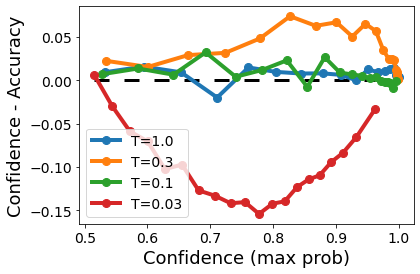

In [63]:
for t, path in paths.items():
    ckpt_dict = checkpoint_utils.load_checkpoint(path)
    ens_probs = ckpt_dict["ensemble_predicted_probs"]
    ens_probs = ens_probs.reshape((25000, 2))
    curve = metrics.calibration_curve(ens_probs, labels)
    plt.plot(curve['confidence'], curve['confidence'] - curve['accuracy'], linewidth=4, marker='o', markersize=8, 
         label="T={}".format(t), zorder=3)
    
plt.ylabel('Confidence - Accuracy', fontsize=18)
plt.xlabel('Confidence (max prob)', fontsize=18)
plt.plot(onp.linspace(onp.min(curve['confidence']), onp.max(curve['confidence']), 10), 
         onp.zeros(10), 'k--', dashes=(5, 5), linewidth=3, zorder=2)
# ticks = 1.0 - onp.logspace(onp.log(0.8), onp.log(0.5), 6, base=onp.e)
# plt.xticks(ticks, fontsize=22)    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)